In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from arch import arch_model

In [2]:
df=pd.read_csv("C:\\Users\\Bogdan\\OneDrive - University of Warwick\\Desktop\\Temp prediction\\MIDLAND TEXAS, TX US.csv")
df['DATE'] = pd.to_datetime(df['DATE'],format='%Y-%m-%d')
df=df.set_index('DATE')
df['TCELSIUS'] = (df['TAVG'] - 32) * 5/9
df=df.drop(columns=['TMAX','TMIN','STATION','TAVG'])
df = df.asfreq(pd.infer_freq(df.index))
#too many datapoints for an SARIMAX (0,1,0)(4,0,4,365)
df = df.resample('M').mean()

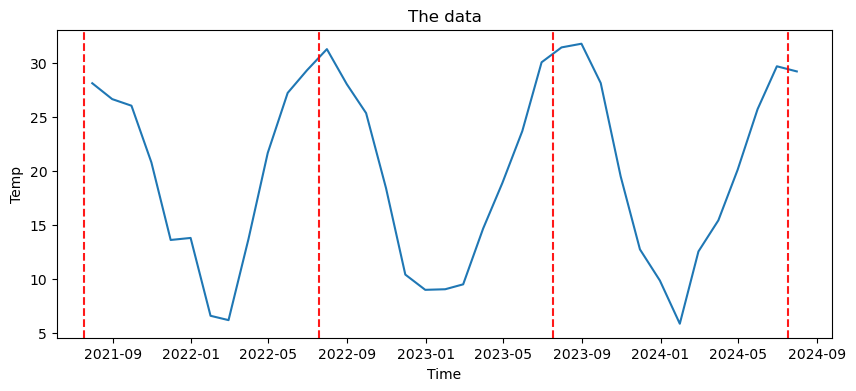

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('The data')
plt.xlabel('Time')
plt.ylabel('Temp')
for year in range(2021,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-18'),color='r',linestyle='--',alpha=0.9)
plt.show()

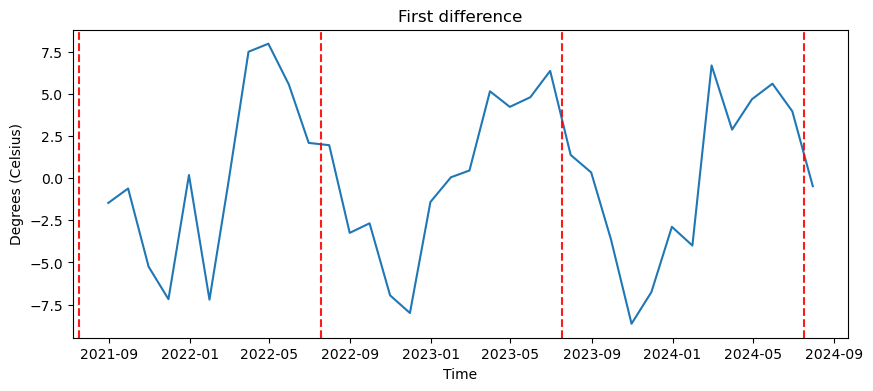

In [4]:
first_diff = df.diff()[1:]
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First difference')
plt.xlabel('Time')
plt.ylabel('Degrees (Celsius)')
for year in range(2021,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-18'),color='r',linestyle='--',alpha=0.9)
plt.show()

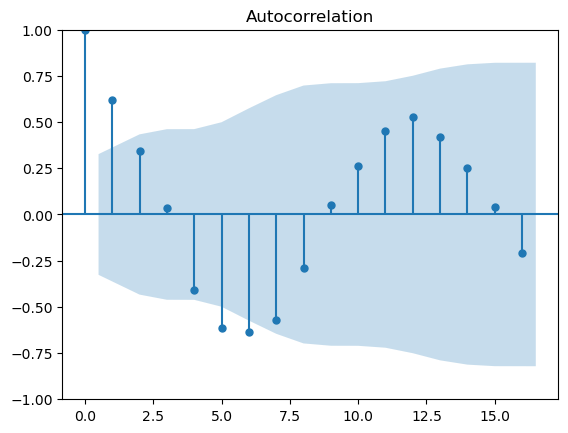

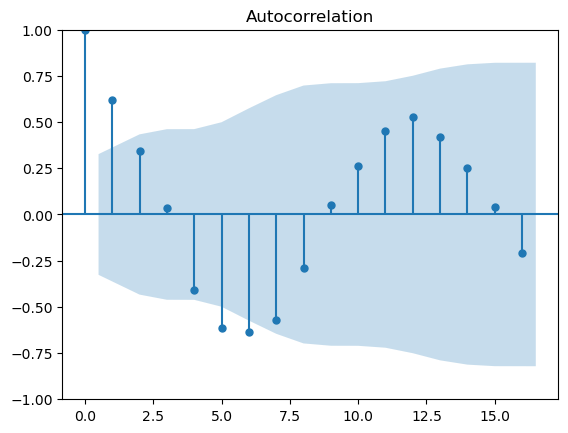

In [5]:
plot_acf(first_diff)

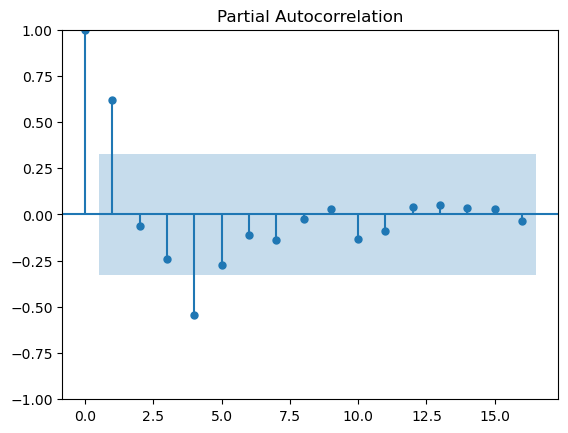

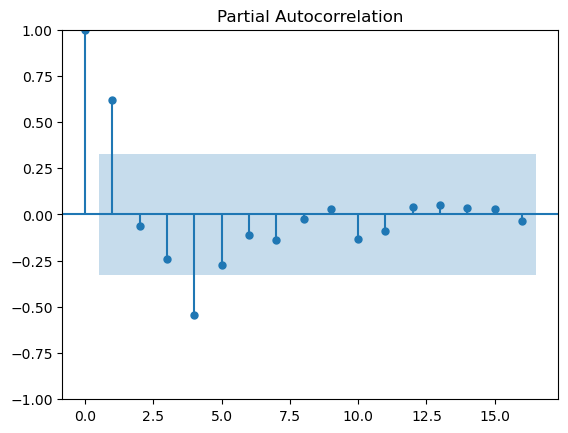

In [6]:
plot_pacf(first_diff['TCELSIUS'])

## SARIMAX(0,1,0)(1,0,1,12)

In [7]:
train_end=datetime(2024,1,31)
test_end=datetime(2024,7,31)

train_data=df[:train_end+timedelta(days=1)]
test_data=df[train_end+timedelta(days=1):] #6 months
print(test_data)

             TCELSIUS
DATE                 
2024-02-29  12.567050
2024-03-31  15.448029
2024-04-30  20.129630
2024-05-31  25.734767
2024-06-30  29.703704
2024-07-31  29.228395


In [8]:
integrated_order=(0,1,0)
seasonal_order = (1,0,1,12)

model = SARIMAX(train_data, order=integrated_order , seasonal_order=seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             TCELSIUS   No. Observations:                   31
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -78.200
Date:                              Mon, 22 Jul 2024   AIC                            162.401
Time:                                      19:39:07   BIC                            166.604
Sample:                                  07-31-2021   HQIC                           163.745
                                       - 01-31-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9985      0.186      5.377      0.000       0.635       1.362
ma.S.L12      -0.88

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [9]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residual=test_data['TCELSIUS'] - predictions
print(predictions)

DATE
2024-02-29     5.905534
2024-03-31    11.648954
2024-04-30    17.183649
2024-05-31    21.889404
2024-06-30    25.750547
2024-07-31    27.264344
Freq: M, Name: predicted_mean, dtype: float64


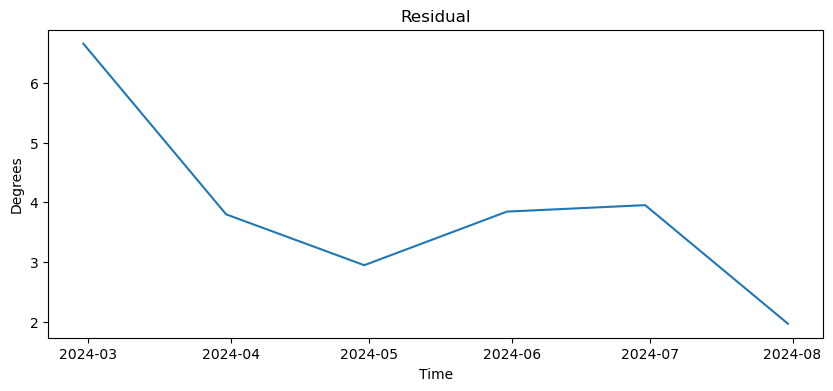

In [10]:
plt.figure(figsize=(10,4))
plt.plot(residual)
plt.title('Residual')
plt.ylabel('Degrees')
plt.xlabel('Time')
plt.show()

In [11]:
print("Mean abs % error:", np.mean(abs(residual/test_data['TCELSIUS'])))

Mean abs % error: 0.2120100868016108


In [12]:
print("Root mean squared error (degrees):", np.sqrt(np.mean(residual**2)))

Root mean squared error (degrees): 4.118238526757232


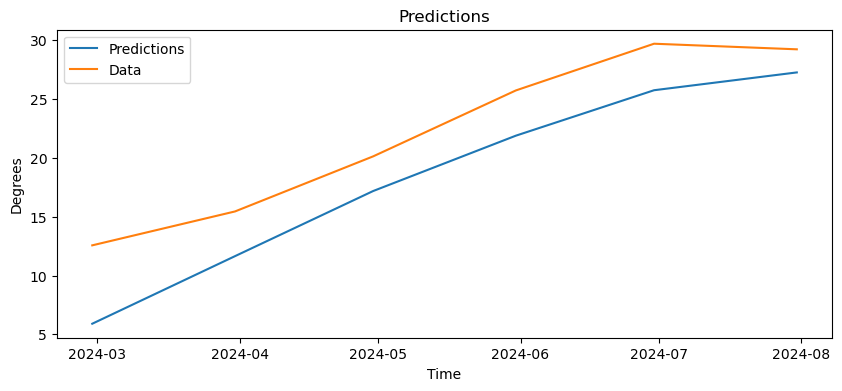

In [13]:
plt.figure(figsize=(10,4))
plt.plot(predictions, label='Predictions')
plt.plot(test_data, label="Data")
plt.title('Predictions')
plt.ylabel('Degrees')
plt.xlabel('Time')
plt.legend()
plt.show()

In [14]:
rolling_predictions=pd.Series(index=test_data.index)

for i in test_data.index:
    train_data=df[:i-timedelta(days=1)]
    model=SARIMAX(train_data, order=integrated_order, seasonal_order=seasonal_order)
    model_fit=model.fit()
    predictions=model_fit.forecast()
    rolling_predictions.loc[i]=predictions
print(rolling_predictions)

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observa

DATE
2024-02-29     5.905534
2024-03-31    17.682896
2024-04-30    19.839819
2024-05-31    24.408231
2024-06-30    30.090014
2024-07-31    31.069620
Freq: M, dtype: float64


c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


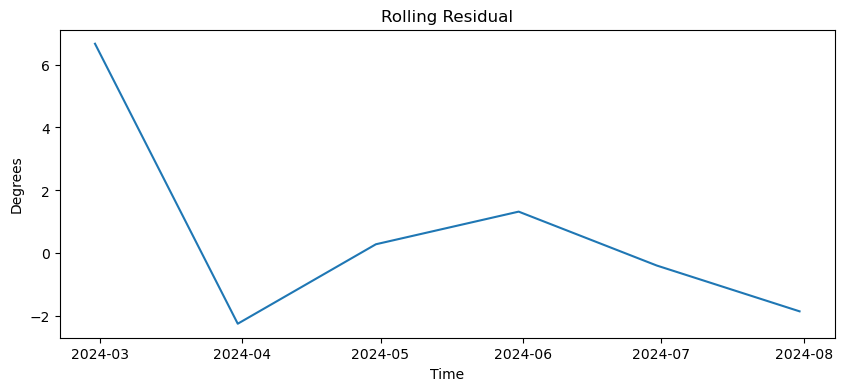

In [15]:
rolling_residual = test_data['TCELSIUS'] - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residual)
plt.title('Rolling Residual')
plt.xlabel('Time')
plt.ylabel('Degrees')
plt.show()

In [16]:
print('Mean abs % error:',np.mean(abs(rolling_residual/test_data['TCELSIUS'])))

Mean abs % error: 0.13611525795965537


In [17]:
print('Root mean squared error (degrees):',np.sqrt(np.mean(rolling_residual**2)))

Root mean squared error (degrees): 3.0208569918430053


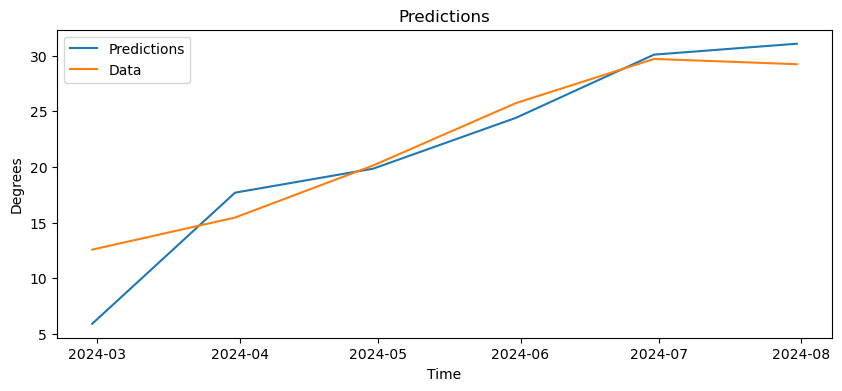

In [18]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, label='Predictions')
plt.plot(test_data, label='Data')
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('Degrees')
plt.legend()
plt.show()